# CFiddle Tutorial and Tour

CFiddle is a Python library for studying how smallish programs are compiled and execute.  It is built to make it easy to experiment and explore.

With it you can:

1. See what the compiler did to your code.
2. Visualize programs with control flow graphs.
3. Compare the performance of different algorithms/compilation flags/inputs.
4. Easily process, plot, or export the results of the above.
5. Do all of the above in Juypter Notebook/Lab.

If you want to get a feel for why CFiddle is useful (and see some more of its features), checkout [the gallery](README.ipynb).  If you want to learn how to use CFiddle, read on!

If you have questions, contact swanson@cs.ucsd.edu.

## Importing CFiddle

Load up everything and set it up to place nicely with Jupyter.

In [1]:
from cfiddle import *


## Building Code

Let's compile a program:

In [2]:
exe = build(code(r"""
extern "C"
int forty_two() {
    return 42;
}"""))[0] 

  0%|          | 0/1 [00:00<?, ?it/s]

There are few things going on here:

1.  `code()` takes a raw Python string, stores it in anonymous file, and returns the filename.
2.  We declared `forty_two()` as `extern "C"` so it's name won't get mangled.
2.  `build()` compiles the code in the file into a dynamic library, so we can execute it later.

`build()` returns a _list_ of objects that represent versions of the compiled code.  In this case, we only compiled one version, so the list has a single entry, which we stored in `exe`.

Before we run `forty_two()`, let's take a look at it's assembly:

In [3]:
exe.asm("forty_two")

forty_two:
.LFB0:
	.file 1 ".cfiddle/builds/anonymous_code/9e88330761e25e87b0442346dc6ddf32.cpp"
	.loc 1 3 17
	.cfi_startproc
	endbr64
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	.loc 1 4 12
	movl	$42, %eax
	.loc 1 5 1
	popq	%rbp
	.cfi_def_cfa 7, 8
	ret
	.cfi_endproc

## Running Code

Let's run the function:

In [4]:
results = run(exe, "forty_two")
display(results[0].return_value)

  0%|          | 0/1 [00:00<?, ?it/s]

42

The `run()` function takes an executable and a function name to invoke.  It returns a _list_ of objects representing the results of execution. In this case, again, there's just one object, because we only executed one function, one time.

## Building Multiple Versions

Here's a more interesting function:

In [5]:
more_interesting = code(r"""
extern "C"
int times_forty_two(int x) {
    return 42 * x;
}

extern "C"
int plus_forty_two(int x) {
    return 42 + x;
}""")

Let's compile it with a specific set of compiler flags:

In [6]:
exe = build(source=more_interesting, 
            build_parameters=arg_map(OPTIMIZE="-O1"))

  0%|          | 0/1 [00:00<?, ?it/s]

The `build_parameters` argument takes a dict that sets `Makefile` variables that CFiddle will use to build the executable, so now `exe[0]` represents a slightly more optimized version of `more_interesting`.

It'd be more interesting two compare two different optimization levels, and CFiddle makes that easy:

In [7]:
exe = build(more_interesting, 
            build_parameters=arg_map(OPTIMIZE=["-O0", "-O1"]))

  0%|          | 0/2 [00:00<?, ?it/s]

The key here is `arg_map()`.  `arg_map()` is the third central tool in CFiddle (along with `build()` and `run()`).

`arg_map()` takes a `dict` that maps argument names to lists of values.  It returns a `list` of `dict`s that map those keys to the corresponding values in all possible combinations.  For instance:

In [8]:
arg_map(a=[1,2], b=[3,4])

[{'a': 1, 'b': 3}, {'a': 1, 'b': 4}, {'a': 2, 'b': 3}, {'a': 2, 'b': 4}]

Or, more relevantly:

In [9]:
arg_map(OPTIMIZE=["-O0", "-O1"])

[{'OPTIMIZE': '-O0'}, {'OPTIMIZE': '-O1'}]

So the `build()` call above, passes a list of `build_parameter` settings and compiles `more_interesting` for each set of values.  The result is two executables:

In [10]:
display(exe)

And we can compare their assembly like so:

In [11]:
from cfiddle.jupyter import *
compare([exe[0].asm("times_forty_two"), exe[1].asm("times_forty_two")], # compare takes two things and puts them side by side.
        [html_parameters(exe[0].get_build_parameters()), html_parameters(exe[1].get_build_parameters())])  # you can provide headers, too.

## Visualizing Control Flow

CFiddle can make it much easier to read assembly language by rendering it as a control flow graph.

In [12]:
loop = build(code(r"""
extern "C"
int loop() { 
    int sum = 0;
    for(int i = 0; i < 10; i++) {
        sum += i;
    }
    return sum;
}
"""))
compare([loop[0].asm("loop"), loop[0].cfg("loop")])

  0%|          | 0/1 [00:00<?, ?it/s]

Cannot determine entrypoint, using 0x00001040.


## Running Multiple Versions

We can use `arg_map()` way with `run()` as well run one or more functions with one or more sets of arguments:

In [13]:
results = run(exe, ["times_forty_two", "plus_forty_two"], arguments=arg_map(x=[2, 4]))

  0%|          | 0/8 [00:00<?, ?it/s]

That ran eight different function calls (which `as_df()` will render as a Pandas data frame):

In [14]:
display(results.as_df())

,OPTIMIZE,function,x
0,-O0,times_forty_two,2
1,-O0,times_forty_two,4
2,-O0,plus_forty_two,2
3,-O0,plus_forty_two,4
4,-O1,times_forty_two,2
5,-O1,times_forty_two,4
6,-O1,plus_forty_two,2
7,-O1,plus_forty_two,4


We could also get it as an array of `dict`s:

In [15]:
display(results.as_dicts())

[{'OPTIMIZE': '-O0', 'x': 2, 'function': 'times_forty_two'},
 {'OPTIMIZE': '-O0', 'x': 4, 'function': 'times_forty_two'},
 {'OPTIMIZE': '-O0', 'x': 2, 'function': 'plus_forty_two'},
 {'OPTIMIZE': '-O0', 'x': 4, 'function': 'plus_forty_two'},
 {'OPTIMIZE': '-O1', 'x': 2, 'function': 'times_forty_two'},
 {'OPTIMIZE': '-O1', 'x': 4, 'function': 'times_forty_two'},
 {'OPTIMIZE': '-O1', 'x': 2, 'function': 'plus_forty_two'},
 {'OPTIMIZE': '-O1', 'x': 4, 'function': 'plus_forty_two'}]

or csv:

In [16]:
results.as_csv("/tmp/out.csv")
display(open("/tmp/out.csv").read())

'OPTIMIZE,function,x\n-O0,times_forty_two,2\n-O0,times_forty_two,4\n-O0,plus_forty_two,2\n-O0,plus_forty_two,4\n-O1,times_forty_two,2\n-O1,times_forty_two,4\n-O1,plus_forty_two,2\n-O1,plus_forty_two,4\n'

or json:

In [17]:
display(results.as_json())

'{"keys": ["OPTIMIZE", "function", "x"], "data": [{"OPTIMIZE": "-O0", "x": 2, "function": "times_forty_two"}, {"OPTIMIZE": "-O0", "x": 4, "function": "times_forty_two"}, {"OPTIMIZE": "-O0", "x": 2, "function": "plus_forty_two"}, {"OPTIMIZE": "-O0", "x": 4, "function": "plus_forty_two"}, {"OPTIMIZE": "-O1", "x": 2, "function": "times_forty_two"}, {"OPTIMIZE": "-O1", "x": 4, "function": "times_forty_two"}, {"OPTIMIZE": "-O1", "x": 2, "function": "plus_forty_two"}, {"OPTIMIZE": "-O1", "x": 4, "function": "plus_forty_two"}]}'

## Making Measurements

Let's see fast `stl::sort()` is.  First, we'll compile it with and without optimizations:

In [18]:
sort_exe = build(code(r"""
#include"cfiddle.hpp"
#include<vector>
#include<algorithm>

extern "C"
int sort(int n) {
    std::vector<int> data(n);
    for(int i = 0;i < n; i++) {
        data[i] = i;
    }
    auto rng = fast_URBG();                       // cfiddle.hpp provides a very fast, low-quality random number generator.
    std::shuffle(data.begin(), data.end(), rng);  
    start_measurement();                          // cfiddle.hpp provides this to mark the begining of a measurement...
    std::sort(data.begin(), data.end());
    end_measurement();                            // ... and the end
    return data[0];                               // Keep the compiler from optimizing away everything.
}"""), build_parameters=arg_map(OPTIMIZE=["-O0", "-O3"]))

  0%|          | 0/2 [00:00<?, ?it/s]

The header `cfiddle.hpp` provides several useful facilities:

1. A very-fast, linear-feedback-based random number generator (and necessary C++ STL boilerplate to use it)
2. `start_measurement()`/`end_measurement()` to mark regions of interest during execution.

Let's run it:

In [19]:
sort_results = run(sort_exe, "sort", arg_map(n=[1000000])) 
sort_results.as_df()

  0%|          | 0/2 [00:00<?, ?it/s]

,OPTIMIZE,function,n,ET
0,-O0,sort,1000000,0.286364
1,-O3,sort,1000000,0.050592


"ET" is for "execution time".

Let's see how long it takes to set up the array, too:

In [20]:
exe = build(code(r"""
#include"cfiddle.hpp"
#include<vector>
#include<algorithm>

extern "C"
int sort(int n) {
    start_measurement("initializing");             // The string shows up in the output in the 'tag' column      
    std::vector<int> data(n);
    for(int i = 0;i < n; i++) {
        data[i] = i;
    }
    auto rng = fast_URBG();                       
    std::shuffle(data.begin(), data.end(), rng);  
    restart_measurement("sorting");               // This ends one tag and begins another.
    std::sort(data.begin(), data.end());
    end_measurement();                           
    return data[0];                              
}"""), build_parameters=arg_map(OPTIMIZE=["-O0", "-O3"]))

  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
results = run(exe, "sort", arg_map(n=[1000000])) 
results.as_df()

  0%|          | 0/2 [00:00<?, ?it/s]

,OPTIMIZE,function,n,tag,ET
0,-O0,sort,1000000,initializing,0.050868
1,-O0,sort,1000000,sorting,0.291333
2,-O3,sort,1000000,initializing,0.004811
3,-O3,sort,1000000,sorting,0.052485


## Drawing Graphs

CFiddle doesn't directly provide data visualization services, but it works well with standard, Jupyter-friendly tools like Pandas and Matplotlib:

<AxesSubplot: xlabel='OPTIMIZE', ylabel='ET'>

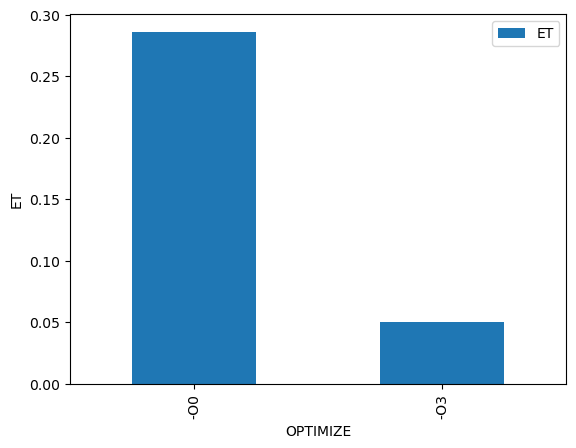

In [22]:
sort_results.as_df().plot.bar(x="OPTIMIZE", y="ET", ylabel="ET")

Line graphs are easy too:

In [23]:
sort_results = run(sort_exe[1], "sort", arg_map(n=range(10000, 100000,1000))) 

  0%|          | 0/90 [00:00<?, ?it/s]

<AxesSubplot: title={'center': 'OPTIMIZE = -O3'}, xlabel='ET', ylabel='ET'>

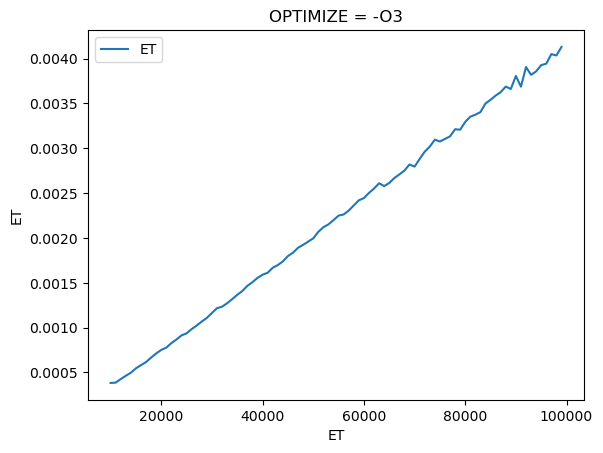

In [24]:
sort_results.as_df().plot.line(x="n", y="ET", xlabel="ET", ylabel="ET", title="OPTIMIZE = -O3")

## Limitations

There are few things to watch out for with CFiddle:

1. It uses heuristics rather than real parsing to identify function names.
    * It can't handle newlines in function prototypes.
    * It only knows about basic C/C++ types.
2. The CFG rendering use [Redare2](https://rada.re/), a very powerful reverse engineering tool.
    * It works on binaries rather than assembly (so the output of `cfg()` doesn't perfectly match the output of `asm()`)
    * Sometimes it gets confused and returns nonsense.
3.  If your code SEGFAULTs it will take Python down with it.